In [1]:
%run IDM_helper_functions.ipynb

In [2]:
from pyddm import Model
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model

In [3]:
import pandas as pd
import os
import scipy.io as sio
import scipy
from statsmodels.stats.anova import AnovaRM
import seaborn as sns


In [5]:
data_path = "/Users/wangjiashun/Desktop/Lexical Decision Data/SpeedAccData.txt"
cols = ["Participant", "Block", "Practice", "SAT", "Stimulus", 
        "Frequency", "Response", "RT", "Censor"]
df = pd.read_fwf(data_path, header=None, names=cols, widths = [2,3,2,2,5,2,2,6,2])
# only include sensored data
df = df[df["Censor"] == 0]

# change type from str to int
df["SAT"] = [-int(i)+2 for i in list(df["SAT"])]

# change type from str to int
df["Frequency"] = [int(i) for i in list(df["Frequency"])]


# change type from str to float
df["RT"] = [float(i) for i in list(df["RT"])]

# remove invalid response
df = df[df["Response"] != -1]

# create a column called correct
df['Correct'] = ((df["Response"]==1) & (df["Frequency"]<3.5)) | ((df["Response"]==0) & (df["Frequency"]>3.5))

# change from boolean to int
df["Correct"] = [int(i) for i in list(df["Correct"])]



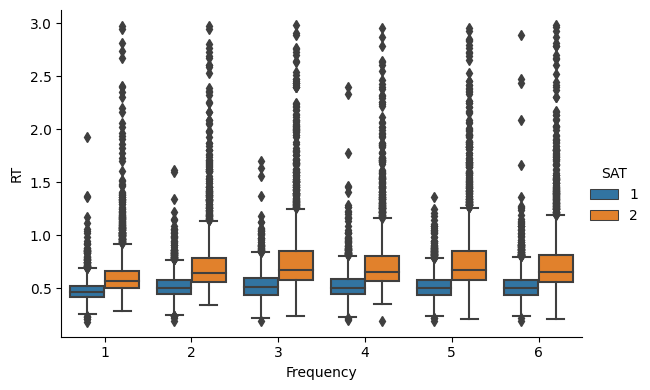

In [8]:
#df_check = df_sub[df_sub.SAT == ]
#df_check = df_sub[df_sub.contrast == 5]

sns.catplot(data=df, x="Frequency", y="RT", hue="SAT", kind="box",
            height=4, aspect=6/4)

In [104]:
Participant = 0
Frequency = 0
SAT = 0

In [41]:
i=1
for Participant in range(17):
    if Participant+1 ==2:
        continue
    for Frequency in range(6):
        for SAT in range(2):
            print(i)
            i+=1
    
            df_cond = df[(df["Participant"]==Participant+1)&(df["Frequency"]==Frequency+1)&(df["SAT"]==SAT+1)]

            data_sub = np.stack((np.array((df_cond["RT"])), np.array((df_cond["Correct"]))), axis = 1)
            print(str(Participant+1), str(Frequency+1), str(SAT+1), data_sub.shape)

1
1 1 1 (74, 2)
2
1 1 2 (82, 2)
3
1 2 1 (69, 2)
4
1 2 2 (81, 2)
5
1 3 1 (69, 2)
6
1 3 2 (88, 2)
7
1 4 1 (62, 2)
8
1 4 2 (85, 2)
9
1 5 1 (69, 2)
10
1 5 2 (79, 2)
11
1 6 1 (72, 2)
12
1 6 2 (83, 2)
13
3 1 1 (67, 2)
14
3 1 2 (87, 2)
15
3 2 1 (75, 2)
16
3 2 2 (88, 2)
17
3 3 1 (74, 2)
18
3 3 2 (87, 2)
19
3 4 1 (74, 2)
20
3 4 2 (89, 2)
21
3 5 1 (73, 2)
22
3 5 2 (82, 2)
23
3 6 1 (73, 2)
24
3 6 2 (89, 2)
25
4 1 1 (74, 2)
26
4 1 2 (83, 2)
27
4 2 1 (71, 2)
28
4 2 2 (89, 2)
29
4 3 1 (76, 2)
30
4 3 2 (85, 2)
31
4 4 1 (70, 2)
32
4 4 2 (91, 2)
33
4 5 1 (75, 2)
34
4 5 2 (83, 2)
35
4 6 1 (77, 2)
36
4 6 2 (87, 2)
37
5 1 1 (77, 2)
38
5 1 2 (83, 2)
39
5 2 1 (68, 2)
40
5 2 2 (85, 2)
41
5 3 1 (67, 2)
42
5 3 2 (89, 2)
43
5 4 1 (69, 2)
44
5 4 2 (89, 2)
45
5 5 1 (64, 2)
46
5 5 2 (83, 2)
47
5 6 1 (70, 2)
48
5 6 2 (88, 2)
49
6 1 1 (70, 2)
50
6 1 2 (83, 2)
51
6 2 1 (76, 2)
52
6 2 2 (88, 2)
53
6 3 1 (70, 2)
54
6 3 2 (81, 2)
55
6 4 1 (71, 2)
56
6 4 2 (88, 2)
57
6 5 1 (71, 2)
58
6 5 2 (86, 2)
59
6 6 1 (63, 2)
60
6 6

In [9]:
#data_dir = "/Users/wangjiashun/Desktop/SAT-Rafiei/data/data_sub"
df_all = pd.DataFrame(columns = ['Frequency', 'SAT', 'Participant', 'v','a','ter'],)

i=1
for Participant in range(17):
    if Participant+1 ==2:
        continue
    
    for Frequency in range(6):
        for SAT in range(2):
            print(i)
            i+=1
    
            df_cond = df[(df["Participant"]==Participant+1)&(df["Frequency"]==Frequency+1)&(df["SAT"]==SAT+1)]

            data_sub = np.stack((np.array((df_cond["RT"])), np.array((df_cond["Correct"]))), axis = 1)
            samp = Sample.from_numpy_array(data_sub, column_names = [])

            model_fit = Model(name='Simple model (fitted)',
                              drift=DriftConstant(drift=Fittable(minval=0, maxval=6)),
                              noise=NoiseConstant(noise=Fittable(minval=0.1, maxval=2)),
                              bound=BoundConstant(B=Fittable(minval=0.5, maxval=4)),
                              overlay=OverlayNonDecision(nondectime=Fittable(minval=0.1, maxval=1)),
                              dx=.001, dt=.001, T_dur=4)

            fit_adjust_model(samp, model_fit,
                             fitting_method="differential_evolution",
                             lossfunction=LossRobustBIC, verbose=False)
            
            df_sub = pd.DataFrame(columns = ['Frequency', 'SAT', 'Participant', 'v','a','ter'],)

            df_sub = pd.DataFrame({'Frequency':Frequency+1, 
                                   'SAT':SAT+1, 
                                   'participant': Participant + 1,
                                   'v': np.array(model_fit.parameters()['drift']['drift']), 
                                   'a': np.array(model_fit.parameters()['bound']['B']),
                                   'ter': np.array(model_fit.parameters()['overlay']['nondectime'])
                                  }, index=[i])
            
            df_all = df_all.append(df_sub)

            print(df_sub)


1


Info: Params [5.03551201 1.76714298 0.9324583  0.34968886] gave -100.38972864508797


   Frequency  SAT  participant         v         a       ter
2          1    1            1  5.035512  0.932458  0.349689
2


Info: Params [5.51212071 1.52127622 0.78794969 0.37592114] gave -166.1509814050542


   Frequency  SAT  participant         v        a       ter
3          1    2            1  5.512121  0.78795  0.375921
3


Info: Params [3.10512926 1.32590439 0.59893778 0.37489619] gave -84.2598274481571


   Frequency  SAT  participant         v         a       ter
4          2    1            1  3.105129  0.598938  0.374896
4


Info: Params [3.69365641 1.64564335 1.04589287 0.35539763] gave -46.267973453716095


   Frequency  SAT  participant         v         a       ter
5          2    2            1  3.693656  1.045893  0.355398
5


Info: Params [1.80620393 1.96304873 0.97684299 0.34750605] gave 13.942361750632404


   Frequency  SAT  participant         v         a       ter
6          3    1            1  1.806204  0.976843  0.347506
6


Info: Params [2.00502909 1.17205238 0.65244276 0.38104679] gave -25.826635840898604


   Frequency  SAT  participant         v         a       ter
7          3    2            1  2.005029  0.652443  0.381047
7


Info: Params [3.91893171 1.72711569 0.88545245 0.33829643] gave -50.98574152906184


   Frequency  SAT  participant         v         a       ter
8          4    1            1  3.918932  0.885452  0.338296
8


Info: Params [3.98315196 1.48546908 0.71298711 0.39345112] gave -118.10993467520524


   Frequency  SAT  participant         v         a       ter
9          4    2            1  3.983152  0.712987  0.393451
9


Info: Params [4.3123743  1.44603007 0.81464225 0.3511085 ] gave -93.96527957021696


    Frequency  SAT  participant         v         a       ter
10          5    1            1  4.312374  0.814642  0.351108
10


Info: Params [4.80019867 1.93159268 1.1271423  0.35621608] gave -71.7873869628204


    Frequency  SAT  participant         v         a       ter
11          5    2            1  4.800199  1.127142  0.356216
11


Info: Params [5.53324985 1.64997469 0.95464831 0.33733587] gave -119.80483042333731


    Frequency  SAT  participant        v         a       ter
12          6    1            1  5.53325  0.954648  0.337336
12


Info: Params [4.92910404 1.66361724 1.06119241 0.35065822] gave -102.0721583366217


    Frequency  SAT  participant         v         a       ter
13          6    2            1  4.929104  1.061192  0.350658
13


Info: Params [3.98385324 1.49288801 0.80271144 0.31243253] gave -80.71677662564369


    Frequency  SAT  participant         v         a       ter
14          1    1            3  3.983853  0.802711  0.312433
14


Info: Params [5.73543766 1.73021112 1.49006658 0.384516  ] gave -98.98201154921907


    Frequency  SAT  participant         v         a       ter
15          1    2            3  5.735438  1.490067  0.384516
15


Info: Params [2.4789667  1.55575719 0.79769908 0.31799901] gave -29.83255846509023


    Frequency  SAT  participant         v         a       ter
16          2    1            3  2.478967  0.797699  0.317999
16


Info: Params [3.56396399 1.68249322 1.49071702 0.34562105] gave 5.846548750043901


    Frequency  SAT  participant         v         a       ter
17          2    2            3  3.563964  1.490717  0.345621
17


Info: Params [2.47810933 1.61701834 0.87518572 0.31197559] gave -10.522771469729005


    Frequency  SAT  participant         v         a       ter
18          3    1            3  2.478109  0.875186  0.311976
18


Info: Params [2.82029284 1.74206791 1.33507101 0.39629526] gave 43.27133692483221


    Frequency  SAT  participant         v         a       ter
19          3    2            3  2.820293  1.335071  0.396295
19


Info: Params [2.47064486 1.37091736 0.89000524 0.27318624] gave -6.629829499905721


    Frequency  SAT  participant         v         a       ter
20          4    1            3  2.470645  0.890005  0.273186
20


Info: Params [4.07244622 1.66132682 2.64411954 0.10059636] gave 43.50647130813469


    Frequency  SAT  participant         v        a       ter
21          4    2            3  4.072446  2.64412  0.100596
21


Info: Params [2.7843682  0.90480288 0.61780666 0.29175925] gave -88.31851206825402


    Frequency  SAT  participant         v         a       ter
22          5    1            3  2.784368  0.617807  0.291759
22


Info: Params [2.63996456 1.41834469 1.31172392 0.34508885] gave 42.81926760915958


    Frequency  SAT  participant         v         a       ter
23          5    2            3  2.639965  1.311724  0.345089
23


Info: Params [4.25784951 1.65170213 0.95074504 0.33460317] gave -72.08741530574738


    Frequency  SAT  participant        v         a       ter
24          6    1            3  4.25785  0.950745  0.334603
24


Info: Params [4.0184059  1.73112513 1.85641115 0.31370922] gave 9.096502661604644


    Frequency  SAT  participant         v         a       ter
25          6    2            3  4.018406  1.856411  0.313709
25


Info: Params [5.65880464 1.49984115 0.65933643 0.32248782] gave -176.39535040469133


    Frequency  SAT  participant         v         a       ter
26          1    1            4  5.658805  0.659336  0.322488
26


Info: Params [5.01472319 1.43133938 1.01671933 0.31637185] gave -127.18522909553772


    Frequency  SAT  participant         v         a       ter
27          1    2            4  5.014723  1.016719  0.316372
27


Info: Params [3.70208025 1.52385363 0.66511694 0.32535068] gave -100.66933524117646


    Frequency  SAT  participant        v         a       ter
28          2    1            4  3.70208  0.665117  0.325351
28


Info: Params [5.18341774 1.58024025 1.1785873  0.339804  ] gave -115.03546378457469


    Frequency  SAT  participant         v         a       ter
29          2    2            4  5.183418  1.178587  0.339804
29


Info: Params [3.17066964 1.94216215 0.81313252 0.33397677] gave -66.48618946576516


    Frequency  SAT  participant        v         a       ter
30          3    1            4  3.17067  0.813133  0.333977
30


Info: Params [3.09872143 1.52856393 1.00433482 0.33771824] gave -22.647574478594223


    Frequency  SAT  participant         v         a       ter
31          3    2            4  3.098721  1.004335  0.337718
31


Info: Params [5.65380256 1.55172    0.77050848 0.33974504] gave -147.08617374254803


    Frequency  SAT  participant         v         a       ter
32          4    1            4  5.653803  0.770508  0.339745
32


Info: Params [5.73917964 1.96810811 1.53307033 0.32344031] gave -83.6300598035852


    Frequency  SAT  participant        v        a      ter
33          4    2            4  5.73918  1.53307  0.32344
33


Info: Params [4.08081047 1.19040291 0.56356608 0.3276344 ] gave -149.93532299945048


    Frequency  SAT  participant        v         a       ter
34          5    1            4  4.08081  0.563566  0.327634
34


Info: Params [4.57016595 1.91577216 1.2241952  0.34677892] gave -54.15399075261367


    Frequency  SAT  participant         v         a       ter
35          5    2            4  4.570166  1.224195  0.346779
35


Info: Params [4.71623993 1.46823433 0.68709211 0.31701599] gave -146.524472919625


    Frequency  SAT  participant        v         a       ter
36          6    1            4  4.71624  0.687092  0.317016
36


Info: Params [4.13664795 1.8954649  1.17309721 0.3421759 ] gave -44.7486790964411


    Frequency  SAT  participant         v         a       ter
37          6    2            4  4.136648  1.173097  0.342176
37


Info: Params [5.93549112 1.45507153 0.7057383  0.31814984] gave -188.14593266015333


    Frequency  SAT  participant         v         a      ter
38          1    1            5  5.935491  0.705738  0.31815
38


Info: Params [4.93479485 1.28398916 1.3461288  0.33010909] gave -105.32840472924795


    Frequency  SAT  participant         v         a       ter
39          1    2            5  4.934795  1.346129  0.330109
39


Info: Params [5.65831354 1.55924568 0.75602349 0.34479279] gave -143.67596717858328


    Frequency  SAT  participant         v         a       ter
40          2    1            5  5.658314  0.756023  0.344793
40


Info: Params [3.65608755 1.62738114 0.99625805 0.41643265] gave -54.80007809850387


    Frequency  SAT  participant         v         a       ter
41          2    2            5  3.656088  0.996258  0.416433
41


Info: Params [3.83625399 1.68050475 0.82968388 0.33527921] gave -70.88941353965761


    Frequency  SAT  participant         v         a       ter
42          3    1            5  3.836254  0.829684  0.335279
42


Info: Params [4.30463591 1.49885822 0.90858923 0.45779243] gave -108.60351219018528


    Frequency  SAT  participant         v         a       ter
43          3    2            5  4.304636  0.908589  0.457792
43


Info: Params [5.33204955 1.01816211 0.90386299 0.31241282] gave -158.73236357526972


    Frequency  SAT  participant        v         a       ter
44          4    1            5  5.33205  0.903863  0.312413
44


Info: Params [4.00879553 1.17091038 1.02800235 0.39560534] gave -106.95542962199042


    Frequency  SAT  participant         v         a       ter
45          4    2            5  4.008796  1.028002  0.395605
45


Info: Params [5.38816717 1.30841751 0.55999782 0.37013535] gave -167.6456106940257


    Frequency  SAT  participant         v         a       ter
46          5    1            5  5.388167  0.559998  0.370135
46


Info: Params [3.49134794 1.41669895 0.9434365  0.46460574] gave -55.82684135513829


    Frequency  SAT  participant         v         a       ter
47          5    2            5  3.491348  0.943437  0.464606
47


Info: Params [4.45742914 1.27745    0.82706872 0.29319627] gave -115.22647864829077


    Frequency  SAT  participant         v         a       ter
48          6    1            5  4.457429  0.827069  0.293196
48


Info: Params [4.40028259 1.78811401 1.20952851 0.42123738] gave -60.46985552476862


    Frequency  SAT  participant         v         a       ter
49          6    2            5  4.400283  1.209529  0.421237
49


Info: Params [4.13489432 1.66159761 0.92451805 0.2490489 ] gave -74.10117969764443


    Frequency  SAT  participant         v         a       ter
50          1    1            6  4.134894  0.924518  0.249049
50


Info: Params [5.53894481 1.89208831 1.1883555  0.36294216] gave -101.25749823268893


    Frequency  SAT  participant         v         a       ter
51          1    2            6  5.538945  1.188356  0.362942
51


Info: Params [2.27593487 1.86265874 0.99429905 0.21579574] gave 0.9530328386633755


    Frequency  SAT  participant         v         a       ter
52          2    1            6  2.275935  0.994299  0.215796
52


Info: Params [3.7454863  1.68693474 1.01418819 0.42227782] gave -52.491757392847745


    Frequency  SAT  participant         v         a       ter
53          2    2            6  3.745486  1.014188  0.422278
53


Info: Params [1.10490153 1.88892234 1.0503196  0.1964941 ] gave 41.09604641407111


    Frequency  SAT  participant         v        a       ter
54          3    1            6  1.104902  1.05032  0.196494
54


Info: Params [2.85203561 1.84664747 1.07866984 0.42750122] gave 5.503657267662813


    Frequency  SAT  participant         v        a       ter
55          3    2            6  2.852036  1.07867  0.427501
55


Info: Params [1.83917304 1.80636565 0.97002455 0.21813658] gave 17.703181130899022


    Frequency  SAT  participant         v         a       ter
56          4    1            6  1.839173  0.970025  0.218137
56


Info: Params [4.52540366 1.89990586 1.4592221  0.38175555] gave -35.98968816135476


    Frequency  SAT  participant         v         a       ter
57          4    2            6  4.525404  1.459222  0.381756
57


Info: Params [1.94729204 1.92402796 0.94556794 0.27338335] gave 0.4319650768533272


    Frequency  SAT  participant         v         a       ter
58          5    1            6  1.947292  0.945568  0.273383
58


Info: Params [4.37547224 1.92725429 1.32346809 0.38662007] gave -38.557371876225666


    Frequency  SAT  participant         v         a      ter
59          5    2            6  4.375472  1.323468  0.38662
59


Info: Params [1.72505663 1.77461738 1.12072946 0.15725379] gave 45.67359372536502


    Frequency  SAT  participant         v         a       ter
60          6    1            6  1.725057  1.120729  0.157254
60


Info: Params [3.92766058 1.52101041 1.13902155 0.34994886] gave -58.337253600586166


    Frequency  SAT  participant         v         a       ter
61          6    2            6  3.927661  1.139022  0.349949
61


Info: Params [0.81611546 1.28258493 0.70451847 0.17628024] gave 43.8370574520792


    Frequency  SAT  participant         v         a      ter
62          1    1            7  0.816115  0.704518  0.17628
62


Info: Params [3.76880091 1.68795982 1.18507876 0.25668279] gave -34.73455546269549


    Frequency  SAT  participant         v         a       ter
63          1    2            7  3.768801  1.185079  0.256683
63


Info: Params [3.63819393e-08 1.89670377e+00 8.86551191e-01 2.43888069e-01] gave 14.69824263350807


    Frequency  SAT  participant             v         a       ter
64          2    1            7  3.638194e-08  0.886551  0.243888
64


Info: Params [3.02121756 1.97230635 1.1572269  0.31302887] gave 2.2667916442033302


    Frequency  SAT  participant         v         a       ter
65          2    2            7  3.021218  1.157227  0.313029
65


Info: Params [0.         1.71745695 0.90357409 0.1890157 ] gave 44.58069455130419


    Frequency  SAT  participant    v         a       ter
66          3    1            7  0.0  0.903574  0.189016
66


Info: Params [1.36199477 1.77413059 1.28881247 0.20420831] gave 115.77952987680007


    Frequency  SAT  participant         v         a       ter
67          3    2            7  1.361995  1.288812  0.204208
67


Info: Params [3.37365344 1.91813971 1.06852208 0.22602981] gave -25.943073331510995


    Frequency  SAT  participant         v         a      ter
68          4    1            7  3.373653  1.068522  0.22603
68


Info: Params [2.60484344 1.649288   1.15212222 0.30647159] gave 34.646044501931726


    Frequency  SAT  participant         v         a       ter
69          4    2            7  2.604843  1.152122  0.306472
69


Info: Params [4.1152782  1.79931266 1.08266088 0.2183619 ] gave -54.17976940438929


    Frequency  SAT  participant         v         a       ter
70          5    1            7  4.115278  1.082661  0.218362
70


Info: Params [2.19173415 1.6199999  1.00094626 0.33979967] gave 31.951594217145335


    Frequency  SAT  participant         v         a     ter
71          5    2            7  2.191734  1.000946  0.3398
71


Info: Params [3.2533788  1.73746691 0.96275301 0.23865649] gave -33.61065363169515


    Frequency  SAT  participant         v         a       ter
72          6    1            7  3.253379  0.962753  0.238656
72


Info: Params [3.2459053  1.72724428 1.12679282 0.32894581] gave -9.219789682080567


    Frequency  SAT  participant         v         a       ter
73          6    2            7  3.245905  1.126793  0.328946
73


Info: Params [1.21872416 1.74540442 1.08907936 0.15276946] gave 61.38499063063766


    Frequency  SAT  participant         v         a       ter
74          1    1            8  1.218724  1.089079  0.152769
74


Info: Params [3.16159978 1.60878643 1.42476562 0.40063191] gave 28.382129356977405


    Frequency  SAT  participant       v         a       ter
75          1    2            8  3.1616  1.424766  0.400632
75


Info: Params [0.45065617 1.86250487 1.10310598 0.1641947 ] gave 73.39276523989851


    Frequency  SAT  participant         v         a       ter
76          2    1            8  0.450656  1.103106  0.164195
76


Info: Params [1.78053989 1.95225241 1.91126385 0.31764749] gave 168.93071111365455


    Frequency  SAT  participant        v         a       ter
77          2    2            8  1.78054  1.911264  0.317647
77


Info: Params [0.         1.9472391  1.21865034 0.16136093] gave 85.35418120798141


    Frequency  SAT  participant    v        a       ter
78          3    1            8  0.0  1.21865  0.161361
78


Info: Params [0.53477408 1.27510546 1.1579986  0.28716668] gave 215.87278363100438


    Frequency  SAT  participant         v         a       ter
79          3    2            8  0.534774  1.157999  0.287167
79


Info: Params [0.96864038 1.68485177 1.02448431 0.17542291] gave 73.17247931726747


    Frequency  SAT  participant        v         a       ter
80          4    1            8  0.96864  1.024484  0.175423
80


Info: Params [1.85532421 1.76218955 1.94873584 0.24230277] gave 182.14541027600364


    Frequency  SAT  participant         v         a       ter
81          4    2            8  1.855324  1.948736  0.242303
81


Info: Params [0.90445044 1.89190007 1.10918187 0.18323288] gave 60.89156564878843


    Frequency  SAT  participant        v         a       ter
82          5    1            8  0.90445  1.109182  0.183233
82


Info: Params [2.66786745 1.98497466 2.66655183 0.10920531] gave 151.5719166080284


    Frequency  SAT  participant         v         a       ter
83          5    2            8  2.667867  2.666552  0.109205
83


Info: Params [0.53846753 1.34151605 0.76809561 0.21667455] gave 55.91400749926275


    Frequency  SAT  participant         v         a       ter
84          6    1            8  0.538468  0.768096  0.216675
84


Info: Params [1.86497771 1.45921372 1.87452574 0.10958897] gave 160.55976192602927


    Frequency  SAT  participant         v         a       ter
85          6    2            8  1.864978  1.874526  0.109589
85


Info: Params [5.95086731 1.50044836 0.69242475 0.38230665] gave -184.19228151765242


    Frequency  SAT  participant         v         a       ter
86          1    1            9  5.950867  0.692425  0.382307
86


Info: Params [4.35924807 1.63602475 1.18933155 0.39399763] gave -71.52165986460555


    Frequency  SAT  participant         v         a       ter
87          1    2            9  4.359248  1.189332  0.393998
87


Info: Params [2.6202318  1.42951788 0.58016802 0.38859397] gave -80.40200049316374


    Frequency  SAT  participant         v         a       ter
88          2    1            9  2.620232  0.580168  0.388594
88


Info: Params [3.29417075 1.90394537 1.6915989  0.37311376] gave 54.69962839987485


    Frequency  SAT  participant         v         a       ter
89          2    2            9  3.294171  1.691599  0.373114
89


Info: Params [1.42485816 1.88661381 0.78575538 0.394005  ] gave -34.17842120064876


    Frequency  SAT  participant         v         a       ter
90          3    1            9  1.424858  0.785755  0.394005
90


Info: Params [2.07621564 1.65745528 1.24123168 0.40727719] gave 83.88118126340996


    Frequency  SAT  participant         v         a       ter
91          3    2            9  2.076216  1.241232  0.407277
91


Info: Params [4.18573531 1.35114861 0.71025937 0.3766531 ] gave -120.7963593146292


    Frequency  SAT  participant         v         a       ter
92          4    1            9  4.185735  0.710259  0.376653
92


Info: Params [3.76764958 1.82084396 1.41074923 0.41329164] gave -1.3066690482213552


    Frequency  SAT  participant        v         a       ter
93          4    2            9  3.76765  1.410749  0.413292
93


Info: Params [5.23971801 1.7133635  0.84974573 0.38798434] gave -127.57173795828315


    Frequency  SAT  participant         v         a       ter
94          5    1            9  5.239718  0.849746  0.387984
94


Info: Params [2.90684404 1.70189591 1.78914207 0.22772873] gave 68.60864985416953


    Frequency  SAT  participant         v         a       ter
95          5    2            9  2.906844  1.789142  0.227729
95


Info: Params [5.63408587 1.80982155 0.79492616 0.40141395] gave -141.12366335336378


    Frequency  SAT  participant         v         a       ter
96          6    1            9  5.634086  0.794926  0.401414
96


Info: Params [4.33489545 1.83720704 1.5045743  0.40522872] gave -23.873074309174342


    Frequency  SAT  participant         v         a       ter
97          6    2            9  4.334895  1.504574  0.405229
97


Info: Params [2.88363593 1.06135661 0.53837037 0.28900813] gave -226.99250939122595


    Frequency  SAT  participant         v        a       ter
98          1    1           10  2.883636  0.53837  0.289008
98


Info: Params [5.00039952 1.1579948  0.95321953 0.34118961] gave -310.2935993191328


    Frequency  SAT  participant       v        a      ter
99          1    2           10  5.0004  0.95322  0.34119
99


Info: Params [3.03008973 1.97800236 1.05628982 0.27174194] gave -61.073656410500725


     Frequency  SAT  participant        v        a       ter
100          2    1           10  3.03009  1.05629  0.271742
100


Info: Params [3.53428134 1.29066488 0.93896528 0.35359547] gave -142.09227150353712


     Frequency  SAT  participant         v         a       ter
101          2    2           10  3.534281  0.938965  0.353595
101


Info: Params [0.93404132 1.39997468 0.66622598 0.28130892] gave -7.576011189604447


     Frequency  SAT  participant         v         a       ter
102          3    1           10  0.934041  0.666226  0.281309
102


Info: Params [3.63095616 1.95409614 1.23171794 0.36837845] gave -37.36030812875059


     Frequency  SAT  participant         v         a       ter
103          3    2           10  3.630956  1.231718  0.368378
103


Info: Params [4.01912425 1.84122693 1.02497355 0.26741071] gave -130.52971046690507


     Frequency  SAT  participant         v         a       ter
104          4    1           10  4.019124  1.024974  0.267411
104


Info: Params [3.51377804 1.44656334 1.10133275 0.34305447] gave -80.37930257523453


     Frequency  SAT  participant         v         a       ter
105          4    2           10  3.513778  1.101333  0.343054
105


Info: Params [4.86827742 1.92606925 1.10403383 0.268638  ] gave -167.99335338179498


     Frequency  SAT  participant         v         a       ter
106          5    1           10  4.868277  1.104034  0.268638
106


Info: Params [4.31476192 1.78239887 1.66225457 0.31254149] gave -41.26275813143944


     Frequency  SAT  participant         v         a       ter
107          5    2           10  4.314762  1.662255  0.312541
107


Info: Params [4.25644087 1.67772909 0.94686166 0.27400642] gave -166.85667439113544


     Frequency  SAT  participant         v         a       ter
108          6    1           10  4.256441  0.946862  0.274006
108


Info: Params [3.21616144 1.12379656 0.98148374 0.33036031] gave -120.28010578833987


     Frequency  SAT  participant         v         a      ter
109          6    2           10  3.216161  0.981484  0.33036
109


Info: Params [5.27505426 1.47786015 0.74423265 0.33464917] gave -312.2383748289884


     Frequency  SAT  participant         v         a       ter
110          1    1           11  5.275054  0.744233  0.334649
110


Info: Params [5.14610436 1.2895665  0.87095923 0.35906777] gave -306.38148520730414


     Frequency  SAT  participant         v         a       ter
111          1    2           11  5.146104  0.870959  0.359068
111


Info: Params [1.62219207 1.47468157 0.66218538 0.34035365] gave -71.83995150156409


     Frequency  SAT  participant         v         a       ter
112          2    1           11  1.622192  0.662185  0.340354
112


Info: Params [4.05616992 1.68752414 0.9982859  0.39191759] gave -144.50030315523242


     Frequency  SAT  participant        v         a       ter
113          2    2           11  4.05617  0.998286  0.391918
113


Info: Params [1.2795438  1.7524613  0.77694189 0.3275105 ] gave -59.65554767964852


     Frequency  SAT  participant         v         a      ter
114          3    1           11  1.279544  0.776942  0.32751
114


Info: Params [1.96779635 1.49224369 0.93410695 0.36714494] gave 46.682992015226496


     Frequency  SAT  participant         v         a       ter
115          3    2           11  1.967796  0.934107  0.367145
115


Info: Params [2.33652986 1.4994432  0.7470788  0.33269733] gave -80.40709577431032


     Frequency  SAT  participant        v         a       ter
116          4    1           11  2.33653  0.747079  0.332697
116


Info: Params [4.65745308 1.94287888 1.62633501 0.32720462] gave -65.64241853215876


     Frequency  SAT  participant         v         a       ter
117          4    2           11  4.657453  1.626335  0.327205
117


Info: Params [3.83506853 1.82963205 0.94145584 0.3264748 ] gave -142.55297227829658


     Frequency  SAT  participant         v         a       ter
118          5    1           11  3.835069  0.941456  0.326475
118


Info: Params [5.03216975 1.77499368 1.46577451 0.37187447] gave -130.87609817287122


     Frequency  SAT  participant        v         a       ter
119          5    2           11  5.03217  1.465775  0.371874
119


Info: Params [3.36924876 1.43193404 0.70751175 0.34940145] gave -179.12865273631104


     Frequency  SAT  participant         v         a       ter
120          6    1           11  3.369249  0.707512  0.349401
120


Info: Params [4.36466958 1.82833971 1.30497203 0.37035688] gave -90.35854663631699


     Frequency  SAT  participant        v         a       ter
121          6    2           11  4.36467  1.304972  0.370357
121


Info: Params [4.44425385 1.91585054 1.50082803 0.20037608] gave -70.28926327064876


     Frequency  SAT  participant         v         a       ter
122          1    1           12  4.444254  1.500828  0.200376
122


Info: Params [3.1373791  1.30792269 1.00542107 0.29967159] gave -80.35322147363607


     Frequency  SAT  participant         v         a       ter
123          1    2           12  3.137379  1.005421  0.299672
123


Info: Params [1.43096324 0.95450458 0.50252938 0.31289891] gave -48.7651073497007


     Frequency  SAT  participant         v         a       ter
124          2    1           12  1.430963  0.502529  0.312899
124


Info: Params [2.01673678 1.64499627 1.16480503 0.34460617] gave 123.87369841871632


     Frequency  SAT  participant         v         a       ter
125          2    2           12  2.016737  1.164805  0.344606
125


Info: Params [0.7544011  1.6646987  0.88131903 0.27129874] gave 54.80474569557418


     Frequency  SAT  participant         v         a       ter
126          3    1           12  0.754401  0.881319  0.271299
126


Info: Params [1.62136406 1.95718111 1.41540956 0.31577586] gave 204.2667021218515


     Frequency  SAT  participant         v        a       ter
127          3    2           12  1.621364  1.41541  0.315776
127


Info: Params [2.55900539 1.78056326 1.43000057 0.17149128] gave 94.59650714147708


     Frequency  SAT  participant         v         a       ter
128          4    1           12  2.559005  1.430001  0.171491
128


Info: Params [2.87510597 1.89604596 1.44505634 0.30861401] gave 94.4643569039451


     Frequency  SAT  participant         v         a       ter
129          4    2           12  2.875106  1.445056  0.308614
129


Info: Params [3.2110927  1.95732319 1.02726108 0.32270516] gave 24.153601939647025


     Frequency  SAT  participant         v         a       ter
130          5    1           12  3.211093  1.027261  0.322705
130


Info: Params [3.05656978 1.87087521 1.51064014 0.32472513] gave 83.8253268242192


     Frequency  SAT  participant        v        a       ter
131          5    2           12  3.05657  1.51064  0.324725
131


Info: Params [2.29797523 1.34788726 0.96962561 0.23873371] gave 11.104277981113732


     Frequency  SAT  participant         v         a       ter
132          6    1           12  2.297975  0.969626  0.238734
132


Info: Params [2.66990656 1.86061056 1.61169779 0.25751342] gave 139.56630343250896


     Frequency  SAT  participant         v         a       ter
133          6    2           12  2.669907  1.611698  0.257513
133


Info: Params [3.0181717  1.55317865 0.89102834 0.30730178] gave -92.072039000524


     Frequency  SAT  participant         v         a       ter
134          1    1           13  3.018172  0.891028  0.307302
134


Info: Params [3.66958835 1.9016356  1.52310534 0.3447289 ] gave 22.96211729274101


     Frequency  SAT  participant         v         a       ter
135          1    2           13  3.669588  1.523105  0.344729
135


Info: Params [2.25498608 1.62008142 0.87645249 0.33154048] gave -28.077630368013526


     Frequency  SAT  participant         v         a      ter
136          2    1           13  2.254986  0.876452  0.33154
136


Info: Params [2.52197421 1.52868601 1.18040135 0.39159362] gave 63.85838652311448


     Frequency  SAT  participant         v         a       ter
137          2    2           13  2.521974  1.180401  0.391594
137


Info: Params [0.97545211 1.98056759 1.05346071 0.32948269] gave 60.85164280080038


     Frequency  SAT  participant         v         a       ter
138          3    1           13  0.975452  1.053461  0.329483
138


Info: Params [0.77398388 0.9612812  0.75004028 0.33860063] gave 225.89803394103308


     Frequency  SAT  participant         v        a       ter
139          3    2           13  0.773984  0.75004  0.338601
139


Info: Params [2.59764442 1.89908098 1.06575439 0.32506188] gave -7.734452292320832


     Frequency  SAT  participant         v         a       ter
140          4    1           13  2.597644  1.065754  0.325062
140


Info: Params [2.99337049 1.89546403 1.65217679 0.35363664] gave 110.80466662360173


     Frequency  SAT  participant        v         a       ter
141          4    2           13  2.99337  1.652177  0.353637
141


Info: Params [3.55185134 1.93323063 1.15972518 0.32558372] gave -54.83622975035056


     Frequency  SAT  participant         v         a       ter
142          5    1           13  3.551851  1.159725  0.325584
142


Info: Params [3.05784675 1.96860049 1.67596091 0.3766062 ] gave 111.61640315494485


     Frequency  SAT  participant         v         a       ter
143          5    2           13  3.057847  1.675961  0.376606
143


Info: Params [3.16839064 1.85253272 1.17926943 0.30271453] gave -11.461448389327167


     Frequency  SAT  participant         v         a       ter
144          6    1           13  3.168391  1.179269  0.302715
144


Info: Params [2.77271376 1.9168836  1.48904209 0.36250354] gave 108.13487142279


     Frequency  SAT  participant         v         a       ter
145          6    2           13  2.772714  1.489042  0.362504
145


Info: Params [4.05955086 1.20501605 0.86009906 0.27182256] gave -224.42046157345771


     Frequency  SAT  participant         v         a       ter
146          1    1           14  4.059551  0.860099  0.271823
146


Info: Params [4.63279948 1.85372999 1.44458517 0.35235412] gave -81.42319992643877


     Frequency  SAT  participant         v         a       ter
147          1    2           14  4.632799  1.444585  0.352354
147


Info: Params [1.91050065 0.91910329 0.52844117 0.3116897 ] gave -100.36603836912722


     Frequency  SAT  participant         v         a      ter
148          2    1           14  1.910501  0.528441  0.31169
148


Info: Params [2.36322659 1.43539853 1.21662643 0.36073389] gave 91.19146273508403


     Frequency  SAT  participant         v         a       ter
149          2    2           14  2.363227  1.216626  0.360734
149


Info: Params [2.00936151 1.42575851 0.73365701 0.34170703] gave -37.080219946425366


     Frequency  SAT  participant         v         a       ter
150          3    1           14  2.009362  0.733657  0.341707
150


Info: Params [1.43138944 1.29792114 1.14163917 0.32765511] gave 220.8370141138139


     Frequency  SAT  participant         v         a       ter
151          3    2           14  1.431389  1.141639  0.327655
151


Info: Params [4.05377802 1.70665246 1.04913034 0.36495316] gave -131.5219751520933


     Frequency  SAT  participant         v        a       ter
152          4    1           14  4.053778  1.04913  0.364953
152


Info: Params [1.8985961  0.92718258 0.83174779 0.43476297] gave 22.722921137840537


     Frequency  SAT  participant         v         a       ter
153          4    2           14  1.898596  0.831748  0.434763
153


Info: Params [3.0515675  1.84907551 1.20346194 0.2911855 ] gave -2.634874084759698


     Frequency  SAT  participant         v         a       ter
154          5    1           14  3.051568  1.203462  0.291185
154


Info: Params [2.15563532 1.38369293 2.09984327 0.11765807] gave 232.92984556686568


     Frequency  SAT  participant         v         a       ter
155          5    2           14  2.155635  2.099843  0.117658
155


Info: Params [3.58799979 1.7665569  1.0351075  0.33379074] gave -92.48994097139696


     Frequency  SAT  participant      v         a       ter
156          6    1           14  3.588  1.035107  0.333791
156


Info: Params [3.1699699  1.96032922 2.07170803 0.38336279] gave 146.7805794683411


     Frequency  SAT  participant        v         a       ter
157          6    2           14  3.16997  2.071708  0.383363
157


Info: Params [3.23978673 1.40750256 0.78242161 0.32181246] gave -146.9952791910149


     Frequency  SAT  participant         v         a       ter
158          1    1           15  3.239787  0.782422  0.321812
158


Info: Params [4.17329366 1.68772028 1.73552621 0.3410896 ] gave -28.735906425808082


     Frequency  SAT  participant         v         a      ter
159          1    2           15  4.173294  1.735526  0.34109
159


Info: Params [2.62487951 1.56241169 0.97806002 0.28931859] gave -23.309606074557237


     Frequency  SAT  participant        v        a       ter
160          2    1           15  2.62488  0.97806  0.289319
160


Info: Params [1.75071422 0.8773917  0.81029095 0.40392325] gave 36.3865118072968


     Frequency  SAT  participant         v         a       ter
161          2    2           15  1.750714  0.810291  0.403923
161


Info: Params [1.5875483  1.94556389 1.01427004 0.31308038] gave 14.584941130623267


     Frequency  SAT  participant         v        a      ter
162          3    1           15  1.587548  1.01427  0.31308
162


Info: Params [1.51331378 1.32229475 1.08646112 0.43788668] gave 191.1197305433674


     Frequency  SAT  participant         v         a       ter
163          3    2           15  1.513314  1.086461  0.437887
163


Info: Params [2.02001531 1.03812184 0.5617626  0.33883494] gave -107.05957588826982


     Frequency  SAT  participant         v         a       ter
164          4    1           15  2.020015  0.561763  0.338835
164


Info: Params [4.15829342 1.90643131 1.91233078 0.42616483] gave 17.69083157638188


     Frequency  SAT  participant         v         a       ter
165          4    2           15  4.158293  1.912331  0.426165
165


Info: Params [2.89180094 1.81124133 1.07066858 0.30158368] gave -31.64200412142014


     Frequency  SAT  participant         v         a       ter
166          5    1           15  2.891801  1.070669  0.301584
166


Info: Params [3.00212587 1.58391427 1.68727698 0.37507207] gave 85.57129900616985


     Frequency  SAT  participant         v         a       ter
167          5    2           15  3.002126  1.687277  0.375072
167


Info: Params [3.27761861 1.69417204 0.97055003 0.32842747] gave -89.21732710371458


     Frequency  SAT  participant         v        a       ter
168          6    1           15  3.277619  0.97055  0.328427
168


Info: Params [3.20654812 1.48724318 1.25880891 0.44247322] gave -9.947325828757034


     Frequency  SAT  participant         v         a       ter
169          6    2           15  3.206548  1.258809  0.442473
169


Info: Params [2.92840386 1.96124831 1.11984005 0.25248972] gave -21.16254666914005


     Frequency  SAT  participant         v        a      ter
170          1    1           16  2.928404  1.11984  0.25249
170


Info: Params [4.29610517 1.72519391 1.26511088 0.38626973] gave -97.02317397387858


     Frequency  SAT  participant         v         a      ter
171          1    2           16  4.296105  1.265111  0.38627
171


Info: Params [1.40342889 1.22961389 0.79654393 0.21773647] gave 82.52212568303364


     Frequency  SAT  participant         v         a       ter
172          2    1           16  1.403429  0.796544  0.217736
172


Info: Params [3.19472451 1.77802055 1.39044542 0.40906298] gave 39.44761771808933


     Frequency  SAT  participant         v         a       ter
173          2    2           16  3.194725  1.390445  0.409063
173


Info: Params [1.11059033 1.57869064 0.98161204 0.22278672] gave 140.30929724271502


     Frequency  SAT  participant        v         a       ter
174          3    1           16  1.11059  0.981612  0.222787
174


Info: Params [1.42945727 1.17014567 0.95083822 0.37330429] gave 162.25794933946418


     Frequency  SAT  participant         v         a       ter
175          3    2           16  1.429457  0.950838  0.373304
175


Info: Params [1.03853865 0.92929723 0.61605618 0.20510813] gave 85.61131526384153


     Frequency  SAT  participant         v         a       ter
176          4    1           16  1.038539  0.616056  0.205108
176


Info: Params [3.73975684 1.95300905 1.67605827 0.39458934] gave 33.95552349652121


     Frequency  SAT  participant         v         a       ter
177          4    2           16  3.739757  1.676058  0.394589
177


Info: Params [1.03002831 1.25936442 0.79714886 0.21677682] gave 121.28067054654977


     Frequency  SAT  participant         v         a       ter
178          5    1           16  1.030028  0.797149  0.216777
178


Info: Params [1.92989925 1.04908953 0.94102437 0.37470473] gave 62.16107963310217


     Frequency  SAT  participant         v         a       ter
179          5    2           16  1.929899  0.941024  0.374705
179


Info: Params [1.66390931 1.72363914 1.24093135 0.18982114] gave 150.364119257461


     Frequency  SAT  participant         v         a       ter
180          6    1           16  1.663909  1.240931  0.189821
180


Info: Params [2.34607551 1.21360918 0.982398   0.38010566] gave 19.784559211069435


     Frequency  SAT  participant         v         a       ter
181          6    2           16  2.346076  0.982398  0.380106
181


Info: Params [4.9330489  1.63018374 0.98001859 0.32439186] gave -216.3843294042843


     Frequency  SAT  participant         v         a       ter
182          1    1           17  4.933049  0.980019  0.324392
182


Info: Params [5.00312137 1.54568918 1.79612056 0.33550029] gave -108.54343499268687


     Frequency  SAT  participant         v         a     ter
183          1    2           17  5.003121  1.796121  0.3355
183


Info: Params [4.36941665 1.69127562 1.20760162 0.30222229] gave -131.11223614622563


     Frequency  SAT  participant         v         a       ter
184          2    1           17  4.369417  1.207602  0.302222
184


Info: Params [2.43128434 0.99266758 0.94994434 0.38884865] gave -40.72977682301668


     Frequency  SAT  participant         v         a       ter
185          2    2           17  2.431284  0.949944  0.388849
185


Info: Params [2.00459873 1.18114292 0.67365661 0.32315163] gave -44.71889059354346


     Frequency  SAT  participant         v         a       ter
186          3    1           17  2.004599  0.673657  0.323152
186


Info: Params [3.15609025 1.89123011 1.4082427  0.44859716] gave 54.68942867674798


     Frequency  SAT  participant        v         a       ter
187          3    2           17  3.15609  1.408243  0.448597
187


Info: Params [3.64909662 1.66841934 1.16213835 0.30115857] gave -72.43293444050377


     Frequency  SAT  participant         v         a       ter
188          4    1           17  3.649097  1.162138  0.301159
188


Info: Params [2.71484617 1.01855643 1.09498797 0.39974489] gave -51.122583736604824


     Frequency  SAT  participant         v         a       ter
189          4    2           17  2.714846  1.094988  0.399745
189


Info: Params [4.89303458 1.95832658 1.36044753 0.32251761] gave -119.04104486459151


     Frequency  SAT  participant         v         a       ter
190          5    1           17  4.893035  1.360448  0.322518
190


Info: Params [3.98577795 1.76370564 1.67029357 0.40062726] gave -9.014336805984009


     Frequency  SAT  participant         v         a       ter
191          5    2           17  3.985778  1.670294  0.400627
191


Info: Params [2.89778126 1.28649733 1.13017961 0.23635696] gave -28.806173959320752


     Frequency  SAT  participant         v        a       ter
192          6    1           17  2.897781  1.13018  0.236357
192


Info: Params [4.13486498 1.66053785 2.33311172 0.26064831] gave 28.97851694908261


     Frequency  SAT  participant         v         a       ter
193          6    2           17  4.134865  2.333112  0.260648


In [14]:
df_all = df_all.rename({
    'v': 'Drift Rate', 
    'a': 'Boundary Separation', 
    "ter": 'Non-decision Time'
}, axis=1)
# df_all.to_csv('DDMresultSAT3.csv')
df_all

,Frequency,SAT,Participant,Drift Rate,Boundary Separation,Non-decision Time,participant
2,1,1,NaN,5.035512,0.932458,0.349689,1.0
3,1,2,NaN,5.512121,0.787950,0.375921,1.0
4,2,1,NaN,3.105129,0.598938,0.374896,1.0
5,2,2,NaN,3.693656,1.045893,0.355398,1.0
6,3,1,NaN,1.806204,0.976843,0.347506,1.0
...,...,...,...,...,...,...,...
189,4,2,NaN,2.714846,1.094988,0.399745,17.0
190,5,1,NaN,4.893035,1.360448,0.322518,17.0
191,5,2,NaN,3.985778,1.670294,0.400627,17.0
192,6,1,NaN,2.897781,1.130180,0.236357,17.0


In [ ]:
frequencycondition = Code "1" means "high frequency word", code "2" means "low frequency word", 
and code "3" means "very low frequency word". Codes 4, 5, and 6 mean

"nonword" (4 is derived from a HF word, 5 is derived from an LF word, and 6

is derived from a VLF word).

In [15]:
import seaborn as sns
#df_all[df_all["contrast"]==3]

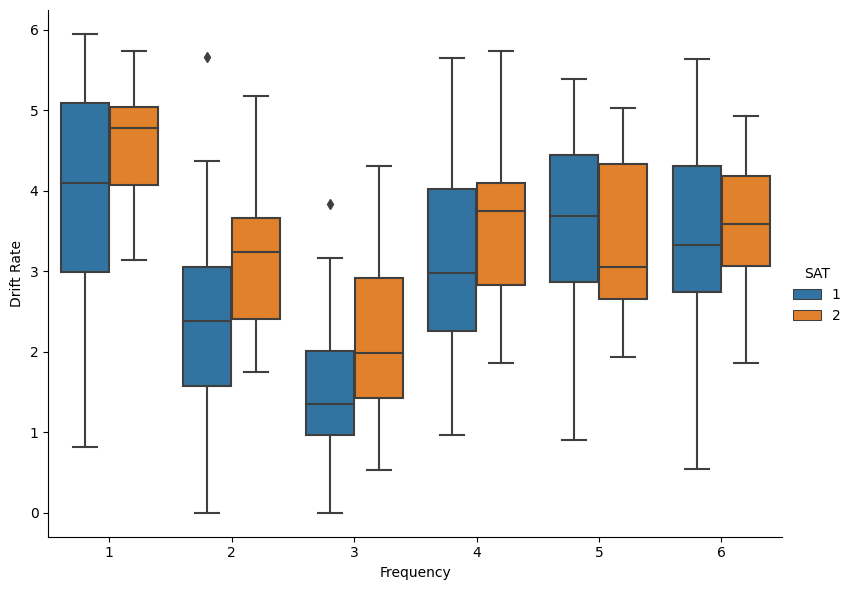

In [16]:
sns.catplot(data=df_all, x="Frequency", y="Drift Rate", hue="SAT", kind="box", errorbar = "ci",
            height=6, aspect=8/6)

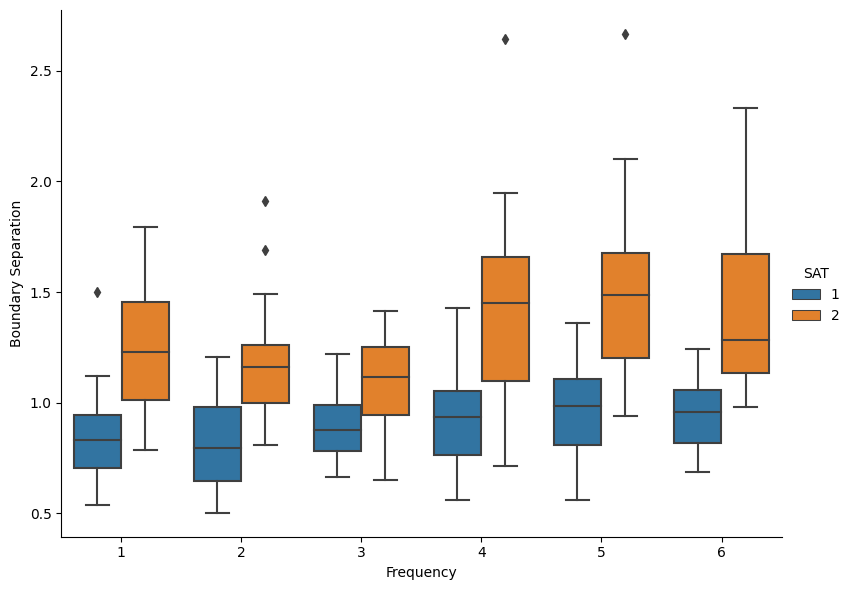

In [17]:
sns.catplot(data=df_all, x="Frequency", y="Boundary Separation", hue="SAT", kind="box",
            height=6, aspect=8/6)

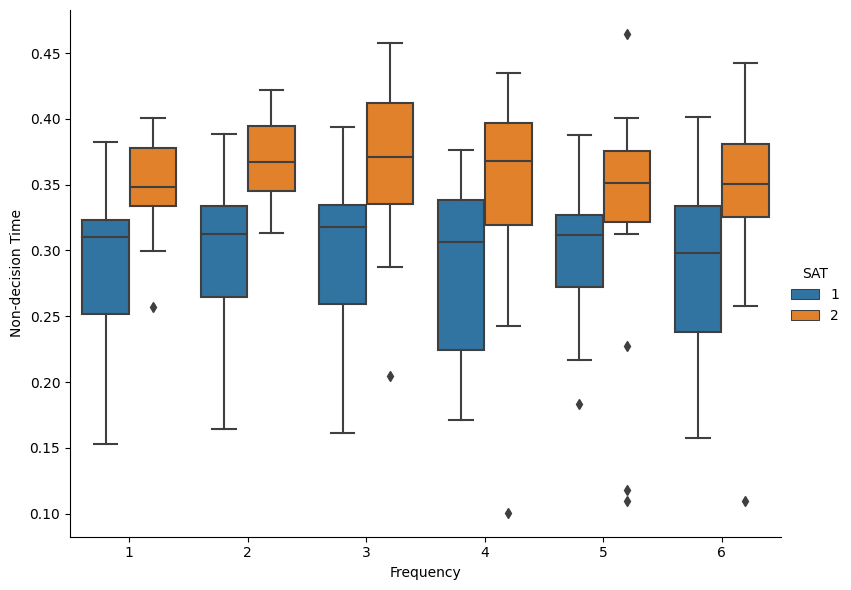

In [18]:
sns.catplot(data=df_all, x="Frequency", y="Non-decision Time", hue="SAT", kind="box",
            height=6, aspect=8/6)

In [53]:
df_example = df_all[df_all["Frequency"] == 6]

In [54]:
df_example_1 = df_example[df_example["SAT"] == 1]
df_example_2 = df_example[df_example["SAT"] == 2]

In [55]:
scipy.stats.ttest_rel(df_example_1["Effective Inhibition"], df_example_2["Effective Inhibition"])

Ttest_relResult(statistic=3.5101889699408733, pvalue=0.003156835503253615)

In [56]:
scipy.stats.ttest_rel(df_example_1["Drift Rate"], df_example_2["Drift Rate"])

Ttest_relResult(statistic=-1.4602448379816055, pvalue=0.16485010713161843)

In [106]:
df_example

,Unnamed: 0,Stimulus Contrast,SAT,participant,Drift Rate,Boundary Separation,Non-decision Time,Effective Inhibition
20,22,5,1,1,0.003643,0.782213,0.100955,11.614850
21,23,5,2,1,1.455478,1.034799,0.184229,8.715260
22,24,5,3,1,2.472537,0.599718,0.258114,4.351838
23,25,5,4,1,1.970795,1.113574,0.232003,8.678523
24,26,5,5,1,2.611156,1.170605,0.243964,5.327644
...,...,...,...,...,...,...,...,...
245,247,5,1,30,0.000000,1.270804,0.100128,14.764992
246,248,5,2,30,2.168604,4.345238,0.176434,13.616276
247,249,5,3,30,3.925519,0.833694,0.303050,6.235077
248,250,5,4,30,3.494954,0.748982,0.306886,6.802331


In [113]:
print(AnovaRM(data=df_example, depvar='Drift Rate',
              subject='participant', within=['SAT']).fit())

              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT 31.2678 4.0000 116.0000 0.0000



In [114]:
print(AnovaRM(data=df_example, depvar='Boundary Separation',
              subject='participant', within=['SAT']).fit())


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT  2.2749 4.0000 116.0000 0.0654



In [115]:
print(AnovaRM(data=df_example, depvar='Non-decision Time',
              subject='participant', within=['SAT']).fit())


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT 18.2300 4.0000 116.0000 0.0000



In [27]:
df[df["SAdf[df["SAT"]==1]T"]==1]

,Unnamed: 0,Frequency,SAT,Participant,Drift Rate,Boundary Separation,Non-decision Time,participant


In [34]:
df[df["SAT"]==1].index

Int64Index([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
             26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
             52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
             78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
            104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
            130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
            156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
            182, 184, 186, 188, 190],
           dtype='int64')

In [35]:
df = pd.read_csv('DDMresultSAT3.csv')
df

,Unnamed: 0,Frequency,SAT,Participant,Drift Rate,Boundary Separation,Non-decision Time,participant
0,2,1,1,NaN,5.035512,0.932458,0.349689,1.0
1,3,1,2,NaN,5.512121,0.787950,0.375921,1.0
2,4,2,1,NaN,3.105129,0.598938,0.374896,1.0
3,5,2,2,NaN,3.693656,1.045893,0.355398,1.0
4,6,3,1,NaN,1.806204,0.976843,0.347506,1.0
...,...,...,...,...,...,...,...,...
187,189,4,2,NaN,2.714846,1.094988,0.399745,17.0
188,190,5,1,NaN,4.893035,1.360448,0.322518,17.0
189,191,5,2,NaN,3.985778,1.670294,0.400627,17.0
190,192,6,1,NaN,2.897781,1.130180,0.236357,17.0


In [ ]:
df["SAT"] = df["SAT"].replace({1: 'Speed', 2: 'Accuracy'})


In [55]:
df.to_csv('DDMresultEJ2008.csv')


In [48]:
df_SAT = df

In [49]:
S = np.array(df_SAT.loc[(df_SAT['SAT'] == "Speed")][["Drift Rate", "Boundary Separation", "Non-decision Time"]])
A = np.array(df_SAT.loc[(df_SAT['SAT'] == "Accuracy")][["Drift Rate", "Boundary Separation", "Non-decision Time"]])
dif = S-A
df_dif = pd.DataFrame(dif,columns = ["Drift Rate", "Boundary Separation", "Non-decision Time"])

In [50]:
df_SAT_melted = pd.melt(df_SAT, id_vars = ["SAT"], value_vars=['Drift Rate', 'Boundary Separation','Non-decision Time'],
                       var_name = "Parameter", value_name = "Value")
df_dif_melted = pd.melt(df_dif, value_vars=['Drift Rate', 'Boundary Separation','Non-decision Time'],
                       var_name = "Parameter", value_name = "Difference")

In [56]:
df_dif_melted.to_csv("DDMdifResultEJ2008.csv") 

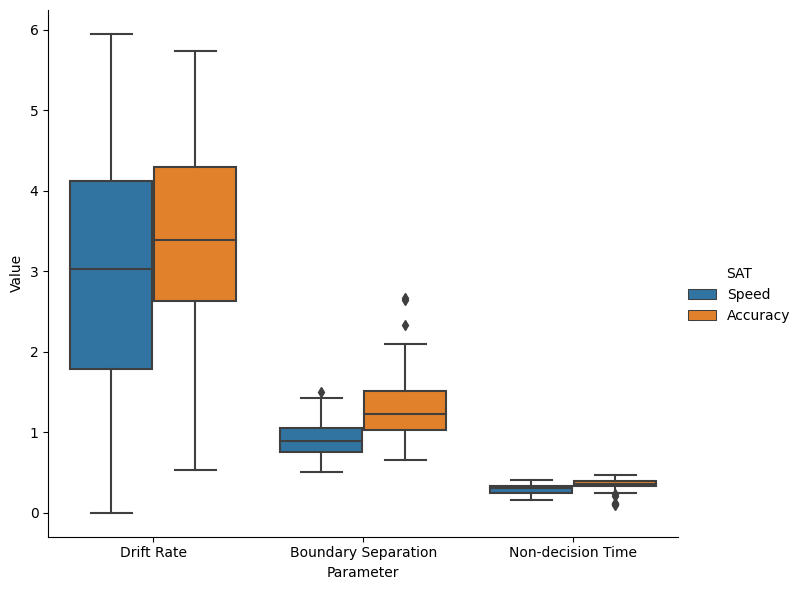

In [51]:
sns.catplot(data=df_SAT_melted, x="Parameter", y="Value", hue="SAT", kind="box",
            height=6, aspect=7/6)

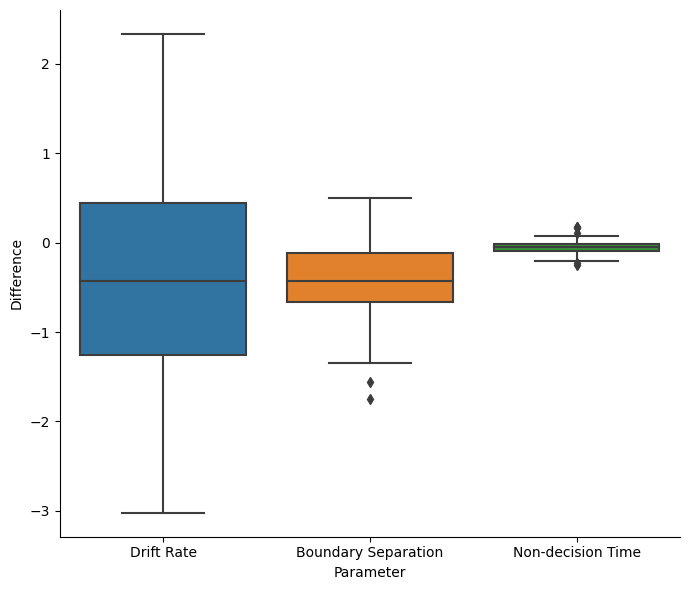

In [52]:
sns.catplot(data=df_dif_melted, x="Parameter", y="Difference", kind="box",
            height=6, aspect=7/6)